<a href="https://colab.research.google.com/github/jenniferamhajduk/AIML_Playground/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
!pip install tqdm
!pip install torchmetrics
!pip install pytorch-ignite

In [220]:
!from timeit import default_timer
from tqdm.auto import tqdm
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from ignite.metrics import ConfusionMatrix, Accuracy
from ignite.engine import Engine, Events
from pathlib import Path
import pandas as pd
import random
print(torch.__version__)
print(torchvision.__version__)


/bin/bash: line 1: from: command not found
2.1.0+cu121
0.16.0+cu121


In [140]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [141]:
train_data = datasets.CIFAR10(
  root="data",
  train=True,
  download=True,
  transform=ToTensor(),
  target_transform=None
)

Files already downloaded and verified


In [142]:
test_data = datasets.CIFAR10(
  root="data",
  train=False,
  download=False,
  transform=ToTensor(),
  target_transform=None
)

In [143]:
len(train_data), len(test_data)

(50000, 10000)

In [144]:
image, label = train_data[0]
image, label

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [145]:
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [146]:
classes_to_idx = train_data.class_to_idx
classes_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [147]:
NUM_CLASSES = len(train_data.classes)

In [148]:
NUM_CLASSES

10

In [149]:
image.shape, label

(torch.Size([3, 32, 32]), 6)

Text(0.5, 1.0, 'frog')

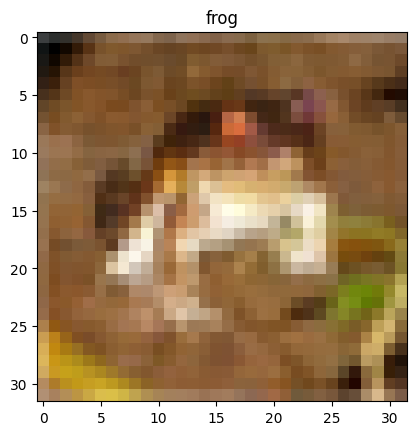

In [150]:
image, label = train_data[0]
image = image.squeeze(dim=1)
image = image.numpy()
image = image.transpose((1,2,0))
plt.imshow(image)
plt.title(classes[label])

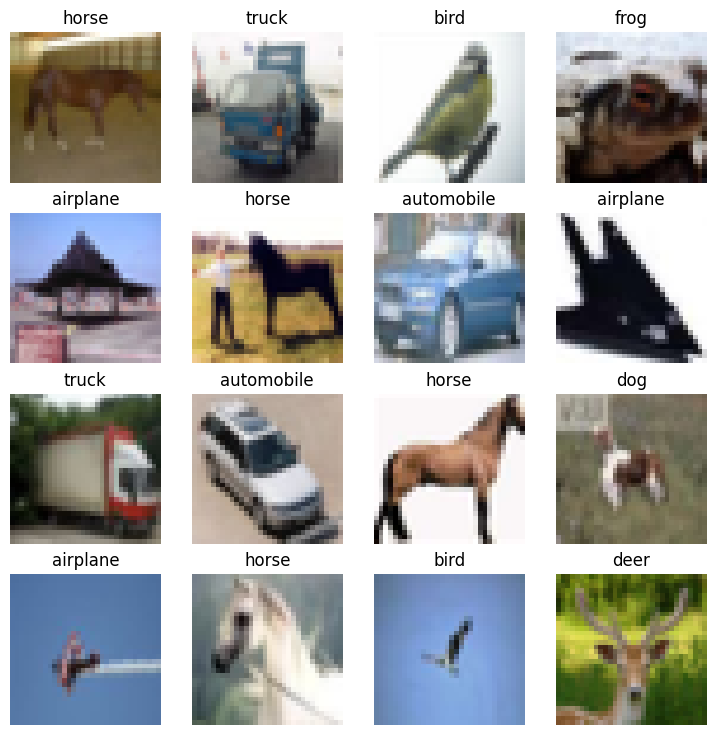

In [151]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
  rand_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[rand_idx]
  image = image.squeeze(dim=1)
  image = image.numpy()
  image = image.transpose((1,2,0))
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze())
  plt.title(classes[label])
  plt.axis(False)

In [152]:
BATCH_SIZE=32

In [153]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [154]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a03c8825a20>,
 <torch.utils.data.dataloader.DataLoader at 0x7a03c8824f10>)

In [155]:
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7a03c8825a20>, <torch.utils.data.dataloader.DataLoader object at 0x7a03c8824f10>)
Length of train_dataloader: 1563 batches of 32
Length of test_dataloader: 313 batches of 32


In [156]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

In [157]:
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [158]:
train_features_batch[0], train_labels_batch[0]

(tensor([[[0.7961, 0.5843, 0.3843,  ..., 0.7686, 0.6471, 0.7451],
          [0.7373, 0.5529, 0.3412,  ..., 0.7412, 0.5882, 0.6824],
          [0.6863, 0.4824, 0.3059,  ..., 0.7490, 0.5922, 0.7255],
          ...,
          [0.5922, 0.5843, 0.5882,  ..., 0.5333, 0.5804, 0.6078],
          [0.5725, 0.5882, 0.5804,  ..., 0.5451, 0.5647, 0.5882],
          [0.5490, 0.6157, 0.5961,  ..., 0.5804, 0.6000, 0.6000]],
 
         [[0.6941, 0.4941, 0.3216,  ..., 0.6902, 0.5569, 0.6431],
          [0.6275, 0.4627, 0.2902,  ..., 0.6667, 0.5020, 0.5804],
          [0.5843, 0.4157, 0.2784,  ..., 0.6745, 0.5059, 0.6235],
          ...,
          [0.4157, 0.4157, 0.4314,  ..., 0.4078, 0.4471, 0.4588],
          [0.4078, 0.4157, 0.4157,  ..., 0.4157, 0.4275, 0.4392],
          [0.3961, 0.4353, 0.4039,  ..., 0.4353, 0.4510, 0.4431]],
 
         [[0.6510, 0.4471, 0.2941,  ..., 0.6549, 0.5255, 0.5843],
          [0.5882, 0.4314, 0.2745,  ..., 0.6275, 0.4627, 0.5294],
          [0.5412, 0.3882, 0.2745,  ...,

Image Size; (32, 32, 3)
Label: 2, label size torch.Size([])


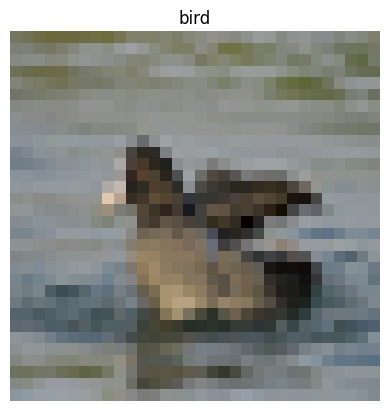

In [159]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]
image = image.squeeze(dim=1)
image = image.numpy()
image = image.transpose((1,2,0))
plt.imshow(image)
plt.title(classes[label])
plt.axis(False)
print(f"Image Size; {image.shape}")
print(f"Label: {label}, label size {label.shape}")


In [160]:
flatten_model = nn.Flatten()
x = train_features_batch[0]
x, x.shape

(tensor([[[0.7961, 0.5843, 0.3843,  ..., 0.7686, 0.6471, 0.7451],
          [0.7373, 0.5529, 0.3412,  ..., 0.7412, 0.5882, 0.6824],
          [0.6863, 0.4824, 0.3059,  ..., 0.7490, 0.5922, 0.7255],
          ...,
          [0.5922, 0.5843, 0.5882,  ..., 0.5333, 0.5804, 0.6078],
          [0.5725, 0.5882, 0.5804,  ..., 0.5451, 0.5647, 0.5882],
          [0.5490, 0.6157, 0.5961,  ..., 0.5804, 0.6000, 0.6000]],
 
         [[0.6941, 0.4941, 0.3216,  ..., 0.6902, 0.5569, 0.6431],
          [0.6275, 0.4627, 0.2902,  ..., 0.6667, 0.5020, 0.5804],
          [0.5843, 0.4157, 0.2784,  ..., 0.6745, 0.5059, 0.6235],
          ...,
          [0.4157, 0.4157, 0.4314,  ..., 0.4078, 0.4471, 0.4588],
          [0.4078, 0.4157, 0.4157,  ..., 0.4157, 0.4275, 0.4392],
          [0.3961, 0.4353, 0.4039,  ..., 0.4353, 0.4510, 0.4431]],
 
         [[0.6510, 0.4471, 0.2941,  ..., 0.6549, 0.5255, 0.5843],
          [0.5882, 0.4314, 0.2745,  ..., 0.6275, 0.4627, 0.5294],
          [0.5412, 0.3882, 0.2745,  ...,

In [161]:
output = flatten_model(x)
print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([3, 32, 32])
Shape after flattening: torch.Size([3, 1024])


In [162]:
class baseline_cifar10(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
    )
  def forward(self, x):
    return self.layer_stack(x)

In [163]:
class baselinev2_cifar10(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layer_stack(x)

In [164]:
class baselineCNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding="same"),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding="same"),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*64,
                  out_features=output_shape)
    )

  def forward(self,x):
    #print("First Layer")
    x = self.conv_block_1(x)
    #print(x.shape)
    #print("Second Layer")
    x = self.conv_block_2(x)
    #print(x.shape)
    #print("Classifier Layer")
    out = self.classifier(x)
    #print(out.shape)
    return out

In [165]:
def Accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [166]:
def print_training_time(
    start: float,
    end: float,
    device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time: .3f} seconds")

In [167]:
def training_loop(model: torch.nn.Module,
                  epochs: int,
                  train_data_loader: torch.utils.data.DataLoader,
                  test_data_loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  optimizer: torch.nn.Module,
                  accuracy):
  print(f"Running: ", model.__class__.__name__)
  train_time_start = default_timer()
  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_loss, train_acc = 0,0
    for batch, (X,y) in enumerate(train_dataloader):
      X = X.to(device)
      y = y.to(device)
      model.train()
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      train_loss += loss
      train_acc += Accuracy(y, y_pred.argmax(dim=1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 500 == 0:
        print(f"Processed batch {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)


    test_loss, test_acc = 0,0
    with torch.inference_mode():
      for X_test, y_test in test_dataloader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        test_pred = model(X_test)
        test_loss += loss_fn(test_pred, y_test)
        test_acc += Accuracy(y_test, y_pred=test_pred.argmax(dim=1))

      test_loss /= len(test_dataloader)
      test_acc  /= len(test_dataloader)

    print(f"Train Accuracy: {train_acc: .2f}%, Train Loss: {loss: .4f} | Test Accuracy: {test_acc: .2f}%, Test Loss: {test_loss: .4f}")
  train_time_end = default_timer()
  total_time = print_training_time(start=train_time_start, end=train_time_end, device=str(next(model.parameters()).device))

In [168]:
def eval_model(
    model: torch.nn.Module,
    test_data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy):
  loss, acc = 0,0
  model.eval().to(device)
  with torch.inference_mode():
    for X, y in tqdm(test_data_loader):
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy(y, y_pred.argmax(dim=1))

      loss /= len(test_data_loader)
      acc /= len(test_data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [169]:
baseline = baseline_cifar10(
    input_shape=3072,
    hidden_units=256,
    output_shape=len(classes)
).to(device)
baseline

baseline_cifar10(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [170]:
baselinev2 = baselinev2_cifar10(
  input_shape=3072,
  hidden_units=256,
  output_shape=len(classes)
).to(device)
baselinev2

baselinev2_cifar10(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [171]:
baselineCNNmodel = baselineCNN(input_shape=3, hidden_units=64, output_shape=10).to(device)
baselineCNNmodel

baselineCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=10, bias=True)
  )
)

In [172]:
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=baselineCNNmodel.parameters(), lr=0.01, momentum=0.9)

In [173]:
baseline_training = training_loop(model=baseline, epochs=epochs, train_data_loader=train_dataloader, test_data_loader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy=Accuracy)
baseline_results = eval_model(model=baseline, test_data_loader=test_dataloader, loss_fn=loss_fn, accuracy=Accuracy)
baseline_results

Running:  baseline_cifar10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  8.33%, Train Loss:  2.3591 | Test Accuracy:  8.56%, Test Loss:  2.3127
Epoch: 1
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  8.33%, Train Loss:  2.3244 | Test Accuracy:  8.56%, Test Loss:  2.3127
Epoch: 2
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  8.33%, Train Loss:  2.3210 | Test Accuracy:  8.56%, Test Loss:  2.3127
Epoch: 3
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  8.33%, Train Loss:  2.2804 | Test Accuracy:  8.56%, Test Loss:  2.3127
Epoch: 4
Processed batch 0/50000 samples
Processed b

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'baseline_cifar10',
 'model_loss': 0.007340047042816877,
 'model_acc': 0.02009584664692692}

In [174]:
baseline_2_training = training_loop(model=baselinev2, epochs=epochs, train_data_loader=train_dataloader, test_data_loader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy=Accuracy)
baseline_2_results = eval_model(model=baselinev2, test_data_loader=test_dataloader, loss_fn=loss_fn, accuracy=Accuracy)
baseline_2_results

Running:  baselinev2_cifar10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  9.07%, Train Loss:  2.3204 | Test Accuracy:  9.26%, Test Loss:  2.3058
Epoch: 1
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  9.07%, Train Loss:  2.3034 | Test Accuracy:  9.26%, Test Loss:  2.3058
Epoch: 2
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  9.07%, Train Loss:  2.3039 | Test Accuracy:  9.26%, Test Loss:  2.3058
Epoch: 3
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  9.07%, Train Loss:  2.3030 | Test Accuracy:  9.26%, Test Loss:  2.3058
Epoch: 4
Processed batch 0/50000 samples
Processed b

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'baselinev2_cifar10',
 'model_loss': 0.007411731407046318,
 'model_acc': 0.04000010370574441}

In [175]:
baseline_cnn_training = training_loop(model=baselineCNNmodel, epochs=epochs, train_data_loader=train_dataloader, test_data_loader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy=Accuracy)
baseline_cnn_results = eval_model(model=baselineCNNmodel, test_data_loader=test_dataloader, loss_fn=loss_fn, accuracy=Accuracy)
baseline_cnn_results

Running:  baselineCNN


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  40.40%, Train Loss:  1.7939 | Test Accuracy:  54.52%, Test Loss:  1.2621
Epoch: 1
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  61.08%, Train Loss:  1.0501 | Test Accuracy:  62.74%, Test Loss:  1.0464
Epoch: 2
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  68.86%, Train Loss:  0.5800 | Test Accuracy:  68.83%, Test Loss:  0.8774
Epoch: 3
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  73.32%, Train Loss:  0.9766 | Test Accuracy:  71.07%, Test Loss:  0.8463
Epoch: 4
Processed batch 0/50000 samples
Pro

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'baselineCNN',
 'model_loss': 0.0011515559162944555,
 'model_acc': 0.26022487162424573}

In [176]:
model_accuracy_all_models = pd.DataFrame([baseline_results,
                                         baseline_2_results,
                                         baseline_cnn_results])
model_accuracy_all_models["model_acc"]

0    0.020096
1    0.040000
2    0.260225
Name: model_acc, dtype: float64

Text(0, 0.5, 'model')

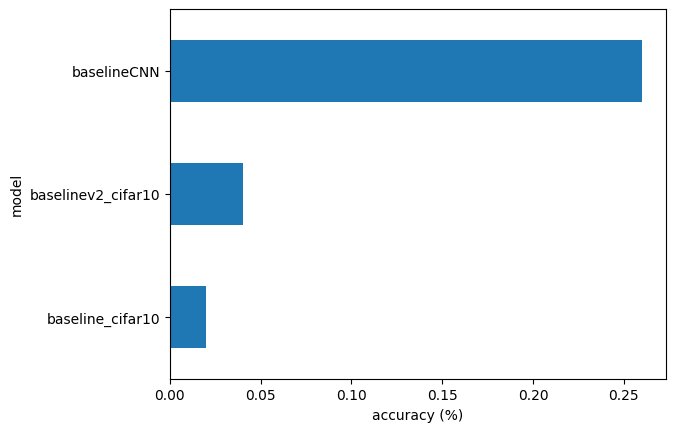

In [177]:
model_accuracy_all_models.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

In [178]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)




In [179]:
image, label = test_data[0][:10]
image.shape, label

(torch.Size([3, 32, 32]), 3)

In [180]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

len(test_samples), len(test_labels)

(9, 9)

Text(0.5, 1.0, 'cat')

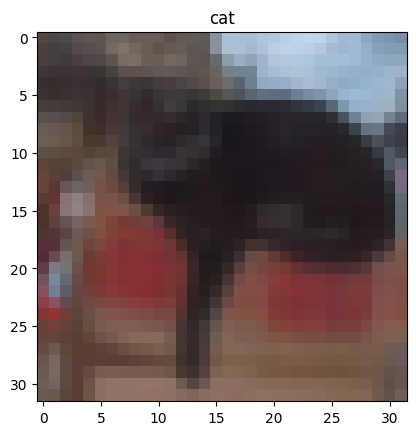

In [181]:
plt.imshow(test_samples[0].numpy().transpose((1, 2, 0)), cmap="RdYlBu")
plt.title(classes[test_labels[0]])

In [182]:
pred_prob = make_predictions(model=baselineCNNmodel,data=test_samples)
pred_prob[:10]

tensor([[2.4867e-02, 2.9312e-03, 2.6147e-01, 7.2189e-02, 2.6747e-01, 1.9292e-02,
         1.3446e-03, 3.4315e-01, 6.2380e-05, 7.2282e-03],
        [5.6118e-07, 8.6148e-05, 1.5048e-02, 4.7415e-04, 2.9142e-03, 9.6366e-01,
         1.6518e-03, 1.6149e-02, 1.6547e-08, 1.4670e-05],
        [1.4982e-11, 1.0000e+00, 6.5567e-14, 1.8496e-12, 1.6191e-13, 6.4290e-14,
         4.7392e-14, 9.2986e-14, 5.2131e-11, 1.3243e-08],
        [1.0298e-02, 7.0521e-04, 9.4258e-02, 3.7935e-01, 1.3558e-01, 8.0497e-03,
         1.4703e-04, 3.6962e-01, 9.2037e-04, 1.0696e-03],
        [3.6604e-07, 1.4062e-06, 4.2274e-04, 6.7117e-03, 2.1041e-01, 1.6536e-05,
         7.8181e-01, 6.2566e-04, 2.7638e-08, 5.1384e-07],
        [8.8170e-03, 5.1293e-06, 3.2122e-01, 1.8868e-02, 3.3024e-01, 4.0179e-04,
         3.2014e-01, 1.4384e-06, 2.8146e-04, 1.3763e-05],
        [9.7896e-06, 1.2505e-05, 8.7839e-05, 6.5564e-04, 9.2708e-04, 4.2081e-03,
         1.6278e-06, 9.9409e-01, 8.0155e-07, 4.0694e-06],
        [4.0512e-01, 5.8280

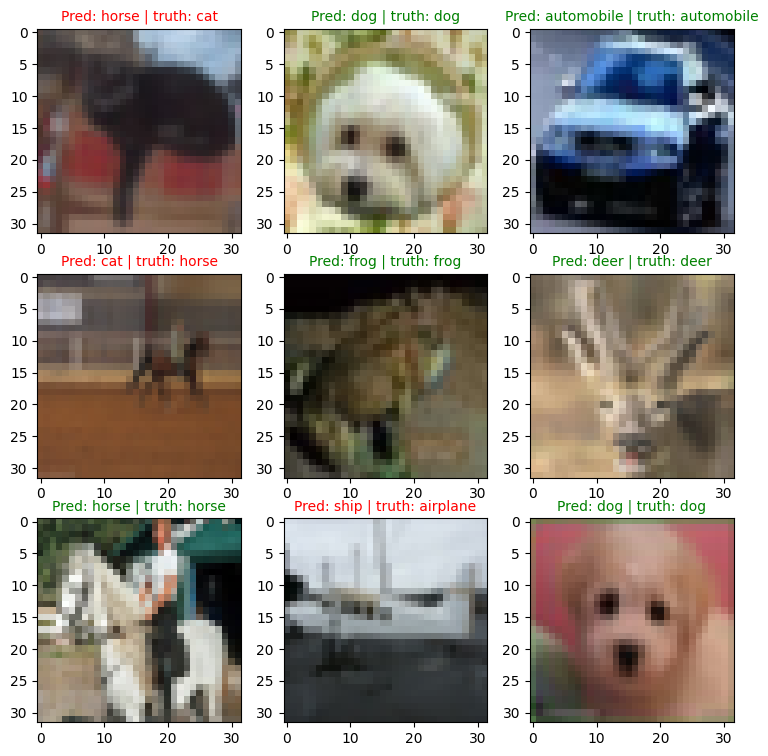

In [183]:
pred_classes = pred_prob.argmax(dim=1)
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.numpy().transpose((1, 2, 0)).squeeze(), cmap="RdYlBu")
  pred_label = classes[pred_classes[i]]
  truth_label = classes[test_labels[i]]
  title_text = f"Pred: {pred_label} | truth: {truth_label}"
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

In [218]:
def evaluate_step(engine, batch, model=baselineCNNmodel):
    model.eval()
    with torch.inference_mode():
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        return y_pred, y

evaluator = Engine(evaluate_step)

metrics = {
    'accuracy': Accuracy(),
    'confusion_matrix': ConfusionMatrix(num_classes=10)
}

for name, metric in metrics.items():
    metric.attach(evaluator, name)

def log_results(engine):
    cm = engine.state.metrics['confusion_matrix'].numpy()
    accuracy = engine.state.metrics['accuracy']
    print("Confusion Matrix:\n", cm)
    print("Accuracy: ", accuracy)

evaluator.add_event_handler(Events.COMPLETED, log_results)

# Assuming `test_dataloader` is defined and ready to use
evaluator.run(test_dataloader)

Confusion Matrix:
 [[726  28  85  25  15   5   6  14  65  31]
 [  9 881   7   5   2   4   6   2  20  64]
 [ 43  14 705  45  59  57  35  25  11   6]
 [ 15  14 119 526  60 175  27  38  14  12]
 [ 17   3 158  62 589  34  25 100  11   1]
 [  8   5  92 134  39 635  11  56   9  11]
 [  9   6 107  86  45  29 703   4   7   4]
 [ 11   7  56  39  37  38   3 797   5   7]
 [ 48  27  21  17   6   4   5   8 850  14]
 [ 28 112  12  16   5   2   3  13  27 782]]
Accuracy:  0.7194


State:
	iteration: 313
	epoch: 1
	epoch_length: 313
	max_epochs: 1
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [224]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)
MODEL_NAME = "baselineCNNmodel"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=baselineCNNmodel.state_dict(), f=MODEL_SAVE_PATH)

saving model to : models/baselineCNNmodel


In [229]:
loaded_CNN_model = baselineCNN(input_shape=3, hidden_units=64, output_shape=10)
loaded_CNN_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_CNN_model.to(device)

baselineCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=10, bias=True)
  )
)